# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
- Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

*Инструкция по выполнению проекта*  
- Откройте файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv. Скачать датасет
- Разделите исходные данные на обучающую, валидационную и тестовую выборки.
- Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
- Проверьте качество модели на тестовой выборке.
- Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

*Описание данных*  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  
сalls — количество звонков,    
minutes — суммарная длительность звонков в минутах,  
messages — количество sms-сообщений,  
mb_used — израсходованный интернет-трафик в Мб,  
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропуски в данных не обнаружены. Столбцы calls и messages имеют тип вещественный тип данных, будет логичнее привести их к целочисленному (количество звонков и отправленных сообщений не может быть дробным).

In [5]:
# переведем количество сообщений к целочисленному типу
df['messages']=df['messages'].astype('int')
# переведем количество звонков к целочисленному типу
df['calls']=df['calls'].astype('int')

Проверим массив на явные дубликаты

In [6]:
df.duplicated().sum()

0

Массив не содержит дубликатов
Проверим группы пользователей по тарифам

In [7]:
df.groupby('is_ultra').count()

,calls,minutes,messages,mb_used
is_ultra,,,,
0,2229,2229,2229,2229
1,985,985,985,985


**Вывод:**
- В датасете содержится 3 214 строк.
- Пропуски и явные дубликаты отсутствуют и в связи с чем данные не нуждаются в предобработке.
- Для столбцов с количество звонков и отправленных сообщений с дробного на целочисленный, т.к. такие показатели не могут быть дробными
- Большинство пользователей предпочитают тариф "Ультра".

## Разбейте данные на выборки

Первым шагом выделим признаки и целевой признак

In [8]:
features=df.drop('is_ultra',axis=1)

In [9]:
target=df['is_ultra']

Разобьём исходный датасет на три выборки (обучающую, валидационную и тестовую) в соотношении 3:1:1

In [10]:
features_train, features_split, target_train, target_split = train_test_split(
    features, target, test_size=0.4, random_state=12345)

В результате применения функции train_test_split получили следующие выборки:

train - обучающуя выборка, которая содержит 60% от исходного датасета (собственно на этой выборке будет проходить обучение моделей)
split - выборка, подлежащая разделению на валидационную и тестовую

In [11]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_split, target_split, test_size=0.5, random_state=12345)

Разбив выборку df_split по полам мы получили две выборки (валидационную и тестовую), размер которых составялет по 20% от исходных данных.

In [12]:
features_valid.shape[0]+features_test.shape[0]+features_train.shape[0]

3214

Все хорошо, размер исходного датасета совпадает с размерами обучающей, валидационной и тестовой выборки.

## Исследуйте модели

### Модель Decision Tree  

Первой обучим модель решающих деревьев и оценим точность на валидационной выборке. Подбирать гиперпараметр максимальной глубины решающего дерева будем с помощью классического цикла.

In [13]:
dt_best_model = None
dt_best_depth = 0
dt_best_accuracy = 0

depth_list = []
accuracy_train_list = []
accuracy_valid_list = []

for depth in range(1, 16):
    # < сделали цикл  для max_depth от 1 до 15 >
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid)# получите предсказания модели
    dt_accuracy= (accuracy_score(target_valid, predictions_valid)) 
   
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))
    
    depth_list.append(depth)
    accuracy_valid_list.append(dt_accuracy)
    
    predictions_train = model.predict(features_train)
    accuracy_train_list.append(accuracy_score(target_train,predictions_train))
    
    if dt_best_accuracy < dt_accuracy:
        dt_best_model = model
        dt_best_accuracy = dt_accuracy
        dt_best_depth = depth
      
                
print('Лучшее значение accuracy для модели Decision Tree составялет: {:.4f}'.format(dt_best_accuracy))
print('Максимальная глубина дерева:', dt_best_depth)

max_depth = 1 : 0.7542768273716952
max_depth = 2 : 0.7822706065318819
max_depth = 3 : 0.7853810264385692
max_depth = 4 : 0.7791601866251944
max_depth = 5 : 0.7791601866251944
max_depth = 6 : 0.7838258164852255
max_depth = 7 : 0.7822706065318819
max_depth = 8 : 0.7791601866251944
max_depth = 9 : 0.7822706065318819
max_depth = 10 : 0.7744945567651633
max_depth = 11 : 0.7620528771384136
max_depth = 12 : 0.7620528771384136
max_depth = 13 : 0.7558320373250389
max_depth = 14 : 0.7589424572317263
max_depth = 15 : 0.7465007776049767
Лучшее значение accuracy для модели Decision Tree составялет: 0.7854
Максимальная глубина дерева: 3


Визуально видно, чо наиболее точно подходит к решению модель с глубиной дерева -3 Для автоматической оценки точного решения добавили условие, что наиболее лучшее решение по точности, когда отклонение равно 0

Визуализируем результаты оценки точности на обучающей и валидационной выборке.

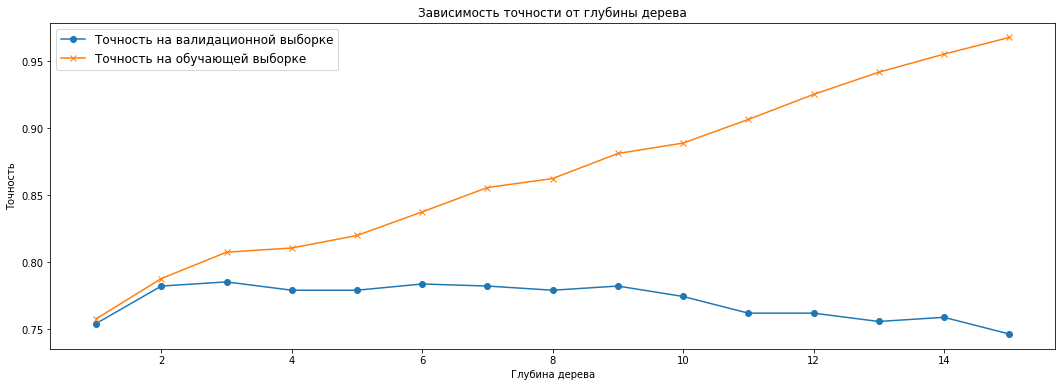

In [14]:
plt.figure(figsize=(18, 6))
plt.plot(depth_list, accuracy_valid_list, marker='o', label='Точность на валидационной выборке')
plt.plot(depth_list, accuracy_train_list, marker='x', label='Точность на обучающей выборке')

plt.xlabel('Глубина дерева')
plt.ylabel('Точность')
plt.title('Зависимость точности от глубины дерева', fontsize=12)
plt.legend(prop={'size':12})
plt.show()

Дополнительно проведем оценку путем случайного подбора гиперпараметров. Для этой модели будем подирать не только глубину дерева, но также попробуем подобрать следующие гиперпараметры:
- criterion - критерий расщепления дерева;
- max_features - количество используемых признаков;
- min_samples_split - минимальное число объектов, при котором выполняется расщепление на узлы;
- min_samples_leaf - минимальное количество объектов в листьях;
- max_leaf_nodes - максимальное количество листовых узлов.

In [15]:
dt_hyperparameters={
    'max_depth': np.arange(1, 30).astype(int),
    'max_features': ['auto', 'sqrt', None],
    'criterion':['gini','entropy'],
    'min_samples_leaf':np.arange(1,50).astype(int),
    'min_samples_split':np.arange(2,100).astype(int),
    'max_leaf_nodes': [None] + list(np.arange(2,50).astype(int))
    }

dt_random_opt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=12345), 
    dt_hyperparameters, n_iter=500, n_jobs=-1,cv=3, random_state=12345) 

dt_model_random = dt_random_opt.fit(features_train, target_train)
print('Лучшие найденные гиперпараметры: ' + str(dt_model_random.best_params_))

dt_random_predict_valid = dt_model_random.predict(features_valid)

dt_random_accuracy = accuracy_score(target_valid, dt_random_predict_valid)

print('Значение accuracy для модели Decision Tree  со случайным подбором гиперпараметров составялет: {:.4f}'
      .format(dt_random_accuracy))

Лучшие найденные гиперпараметры: {'min_samples_split': 23, 'min_samples_leaf': 1, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 28, 'criterion': 'gini'}
Значение accuracy для модели Decision Tree  со случайным подбором гиперпараметров составялет: 0.7869


**Вывод:**
- Обучена модель Decision Tree с с подбором гиперпараметра – глубина решающего дерева;
- Максимальное значение точности классификации на валидационной выборке составляет 78.5% (точность достигнута при глубине дерева = 3);
- Построен график зависимости точности классификации на обучающей и валидационной выборке. Как видно из графика для обучающей выборке с повышением глубины дерева точность повышалась, в то время как для валидационной наблюдается противоположный эффект. При глубине дерева 10 и выше – точность классификации заметно падает, что свидетельствует о переобучении модели. 
- Дополнительно построена модель со случайным подбором нескольких гиперпараметров. Точность классификации этой модели выше примерно на 0.15%, чем у модели с подбором только одного гиперпараметра. Сравним результаты позднее на тестовой выборке.

 ### Модель Random Forest

Обучим перебором двух гиперпараметров - глубина дерева и количество деревьев (перебор циклом)

In [16]:
rf_best_model = None
rf_best_depth = 0
rf_best_accuracy = 0
rf_best_est = 0

for est in range(2, 26):
    for depth in range (1, 26):
        # обучим модель с заданным количеством деревьев
        rf_model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=est,
                                       max_depth=depth) 
        # обучим модель на тренировочной выборке
        rf_model.fit(features_train,target_train)
        # оценим качество модели на тренировочной выборке
        rf_accuracy = rf_model.score(features_valid, target_valid)
        
        result = rf_model.score(features_valid,target_valid) # посчитайте качество модели на валидационной выборке
        if rf_best_accuracy < rf_accuracy:
            rf_best_model = rf_model
            rf_best_accuracy = rf_accuracy
            rf_best_depth = depth
            rf_best_est = est
    
print('Лучшее значение accuracy для модели Random Forest составялет {:.4f}'.format(rf_best_accuracy))
print('Максимальное количество деревьев', rf_best_est)
print('Максимальная глубина дерева', rf_best_depth)

Лучшее значение accuracy для модели Random Forest составялет 0.8056
Максимальное количество деревьев 17
Максимальная глубина дерева 12


**Вывод:**

- Обучена модель Random Forest с с подбором двух гиперпараметров – глубина решающих деревьев и их количество;
- Максимальное значение точности классификации на валидационной выборке составляет 80.5% (точность достигнута при глубине дерева = 12 и количеству деревьев = 17)

### Модель Logistic Regression

Обучим модели без перебора гиперпараметров.

In [17]:
lr_best_model = None
lr_best_accuracy = 0

# модель со штрафной функцией по умолчаню (l2)
lr_l2_model = LogisticRegression( random_state=12345, max_iter= 1000)
lr_l2_model.fit(features_train, target_train)
lr_l2_prediction_valid = lr_l2_model.predict(features_valid)
lr_l2_accuracy = accuracy_score(target_valid, lr_l2_prediction_valid)

#модель без штрафной функции
lr_model = LogisticRegression( random_state=12345, max_iter= 1000, penalty ='none')
lr_model.fit(features_train, target_train)
lr_prediction_valid = lr_model.predict(features_valid)
lr_accuracy = accuracy_score(target_valid, lr_prediction_valid)

if lr_l2_accuracy < lr_accuracy:
    lr_best_model = lr_model
    lr_best_accuracy = lr_accuracy
else:
    lr_best_model = lr_l2_accuracy
    lr_best_accuracy = lr_l2_accuracy

print('Лучшее значение accuracy для модели Logistic Regression составялет {:.4f}'.format(lr_best_accuracy))
print('ЛУчшая модель', lr_best_model)

Лучшее значение accuracy для модели Logistic Regression составялет 0.7558
ЛУчшая модель LogisticRegression(max_iter=1000, penalty='none', random_state=12345)


**Вывод:**
- Были обучены две модели логистической регрессии (со штрафми и без);
- Модель без штрафов показала более высокую точность классификации на валидационнй выборке - именно эта модель будет проверена на тестовой выборке.

### Сопоставление результатов

In [18]:
pd.Series([dt_best_accuracy, dt_random_accuracy, rf_best_accuracy, lr_best_accuracy], 
          ['DT', 'RS_DT', 'RF', 'LR']).sort_values(ascending=False)

RF       0.805599
RS_DT    0.786936
DT       0.785381
LR       0.755832
dtype: float64

**Вывод:**
- В рамках исследования были обучены модели Decision Tree, Random Forest и Logistic Regression;
- гиперпараметры моделей подбирались как перебором, так и случаным образом с применением функции RandomizedSearchCV;
- по результатам исследования различных моделей было установлено, что на валидационной выборке наилучший результат дала модель Random Forest с глубиной деревьев равным 12 и количеством деревьев равным 17;
- самый низкий результата дала Logistic Regression; 

Следующим этапом проверим все модели на тестовой выборке.

## Проверьте модель на тестовой выборке

Протестируем обученные модели на тестовой выборке и сравним результаты

In [19]:
#Объединим тестовую и валидационную выборки для тестирования модели   
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

In [20]:
#проверим выбранную модель Random Forest и гипараметры для тестовой выборки
test_model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=12,
                                       max_depth=17) 
# обучим модель на тренировочной выборке
test_model.fit(features_train_valid,target_train_valid)
# оценим качество модели на тренировочной выборке
test_accuracy = test_model.score(features_test, target_test)
print(test_accuracy)

0.8040435458786936


**Вывод:**
- Высокую точность классификации на тестовой выборке показала модель Random Forest, значение показателя accuracy (точность) составляет 80.1%;
- В целом все модели за исключением логистической регрессии прошли заданный порог точности 0.75;
- Также можно заметить закономерность, что модели со случайным подбором гиперпараметров показывают более высокую точность классификации по сравнению с моделями в которых подбирался 1-2 гиперпараметра.

## (бонус) Проверьте модели на адекватность

Зададим функцию, которая будет выдавать ответ 0 или 1 случайным образом и сравним результат оценки точности с результатам оценки модели чтобы оценить ее адекватность.

In [21]:
random_predictions = np.random.randint(low = 0, high = 2, size = target_test.shape[0]) 

#Подсчитаем долю правильных ответов
accuracy = accuracy_score(target_test, random_predictions)

#Выведем долю правильных ответов
print('Значение точности классификации для модели случайного поиска составялет {:.4f}'.format(accuracy))

Значение точности классификации для модели случайного поиска составялет 0.5086



<h2> Комментарий студента <a class="tocSkip"> </h2>

Кирилл, добрый день! Спасибо за обратную связь, а особенно за рекомендации и полезные ссыллки.  Внимательно изучу и буду использовать в дальнейшем обучении. 
</div> 


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [ ] Весь код исполняется без ошибок
- [ ] Ячейки с кодом расположены в порядке исполнения
- [ ] Выполнено задание 1: данные загружены и изучены
- [ ] Выполнено задание 2: данные разбиты на три выборки
- [ ] Выполнено задание 3: проведено исследование моделей
    - [ ] Рассмотрено больше одной модели
    - [ ] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [ ] Написаны выводы по результатам исследования
- [ ] Выполнено задание 3: Проведено тестирование
- [ ] Удалось достичь accuracy не меньше 0.75
